![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Advanced Futures Trading Strategies

"Advanced Futures Trading Strategies" by Robert Carver lays the foundation for building a systematic trading system.

Although the book focuses on futures trading, its concepts are foundational and applicable to other financial instruments.

This notebook replicates the book's initial strategies, emphasizing data processing, metric building, and position size management with risk targeting.

# Data aquisition

In [1]:
from datetime import datetime
from QuantConnect import Resolution
from QuantConnect.Securities import Futures
from QuantConnect.Data.UniverseSelection import *
from helper import calculate_and_merge_returns, summarize_statistics, calculate_contract_risk, simulate_buy_and_hold, calculate_rolling_costs, calculate_combined_std
import numpy as np
from scipy.stats import skew

In [2]:
# Initialize QuantBook
qb = QuantBook()

# Updated Instruments Dictionary
instruments = {
    'ES': { # S&P 500
        'multiplier': 50,
        'tick_value': 0.25,
        'minimum_fluctuation': 12.50,
        'spread': 0.25, # diferencia entre bid y ask
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.SP500EMini,
        'resolution': Resolution.Daily,
        'multiply_close': False # Ajuste manual que tengo que hacer para algunos instrumentos
    },
    'MES': {
        'multiplier': 5,
        'tick_value': 0.25,
        'minimum_fluctuation': 1.25,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.MicroSP500EMini,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'ZN': {     # 10-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.015625,
        'minimum_fluctuation': 15.625,
        'spread': 0.015625,
        'commission': 2.50,
        'rolling_months': [6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y10TreasuryNote,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'ZF': {  # 5-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.0078125,
        'minimum_fluctuation': 7.8125,
        'spread': 0.0078125,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y5TreasuryNote,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'ZB': {  # 30-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.03125,
        'minimum_fluctuation': 31.25,
        'spread': 0.03125,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y30TreasuryBond,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'ZW': {  # Wheat
        'multiplier': 50,
        'tick_value': 0.25,
        'minimum_fluctuation': 12.50,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.SRWWheat,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'CL': {  # Crude Oil
        'multiplier': 1000,
        'tick_value': 0.01,
        'minimum_fluctuation': 10.00,
        'spread': 0.01,
        'commission': 2.50,
        'rolling_months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Energies.CrudeOilWTI,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'GC': {  # Gold
        'multiplier': 100,
        'tick_value': 0.1,
        'minimum_fluctuation': 10.00,
        'spread': 0.1,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Gold,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'HE': {  # Lean Hog
        'multiplier': 400,
        'tick_value': 0.00025,
        'minimum_fluctuation': 10.00,
        'spread': 0.025,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 7, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Meats.LeanHogs,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'GF': {  # Feeder Cattle
        'multiplier': 500,
        'tick_value': 0.00025,
        'minimum_fluctuation': 12.50,
        'spread': 0.00025,
        'commission': 2.50,
        'rolling_months': [1, 3, 4, 5, 8, 9, 10, 11],
        'subscription_type': 'Future',
        'subscription_details': Futures.Meats.FeederCattle,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'ZS': {  # Soy Bean
        'multiplier': 50,
        'tick_value': 0.0025,
        'minimum_fluctuation': 12.50,
        'spread': 0.0025,
        'commission': 2.50,
        'rolling_months': [1, 3, 5, 7, 8, 9, 11],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.Soybeans,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'ZC': {  # Corn
        'multiplier': 50,
        'tick_value': 0.0025,
        'minimum_fluctuation': 12.50,
        'spread': 0.0025,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.Corn,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'NG': {  # Natural Gas
        'multiplier': 10000,
        'tick_value': 0.001,
        'minimum_fluctuation': 10.00,
        'spread': 0.001,
        'commission': 2.50,
        'rolling_months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Energies.NaturalGas,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'SI': {  # Silver
        'multiplier': 5000,
        'tick_value': 0.005,
        'minimum_fluctuation': 25.00,
        'spread': 0.005,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Silver,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'HG': {  # Copper
        'multiplier': 25000,
        'tick_value': 0.0005,
        'minimum_fluctuation': 12.50,
        'spread': 0.0005,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Copper,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'NQ': {  # Nasdaq
        'multiplier': 20,
        'tick_value': 0.25,
        'minimum_fluctuation': 5.00,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.NASDAQ100EMini,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'MGC': { # Micro gold
        'multiplier': 10,
        'tick_value': 0.1,
        'minimum_fluctuation': 1.00,
        'spread': 0.1,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.MicroGold,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'SIL': { # Micro silver
        'multiplier': 1000,
        'tick_value': 0.005,
        'minimum_fluctuation': 5.00,
        'spread': 0.005,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.MicroSilver,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'USDMXN': { #forex exchange rate to mxn
        'subscription_type': 'Forex',
        'subscription_details': 'USDMXN',
        'resolution': Resolution.Daily,
        'multiplier': 1,
        'multiply_close': False
    }
}


In [3]:
# # Define Instruments Dictionary
# instruments = {
#     'ES': {
#         'multiplier': 50,
#         'tick_value': 0.25,
#         'minimum_fluctuation': 12.50,
#         'spread': 0.25,
#         'commission': 2.50,
#         'rolling_months': [3, 6, 9, 12],
#         'subscription_type': 'Future',
#         'subscription_details': Futures.Indices.SP500EMini,
#         'resolution': Resolution.Daily
#     },
#     'MES': {
#         'multiplier': 5,
#         'tick_value': 0.25,
#         'minimum_fluctuation': 1.25,
#         'spread': 0.25,
#         'commission': 2.50,
#         'rolling_months': [3, 6, 9, 12],
#         'subscription_type': 'Future',
#         'subscription_details': Futures.Indices.MicroSP500EMini,
#         'resolution': Resolution.Daily
#     },
#     'USDMXN': {
#         'subscription_type': 'Forex',
#         'subscription_details': 'USDMXN',
#         'resolution': Resolution.Daily,
#         'multiplier': 1,

#     }
# }



In [36]:
from datetime import datetime

# Add Subscriptions for Futures and Forex
subscriptions = {}
for symbol, details in instruments.items():
    if details['subscription_type'] == 'Future':
        future = qb.AddFuture(details['subscription_details'], details['resolution'])
        subscriptions[symbol] = future.Symbol
    elif details['subscription_type'] == 'Forex':
        forex = qb.AddForex(details['subscription_details'], details['resolution'])
        subscriptions[symbol] = forex.Symbol

# Set Historical Data Range
general_start_date = datetime(2007, 1, 1)
specific_start_date = datetime(2013, 1, 1)  # Fecha específica para SI
end_date = datetime.now()
trading_days_per_year = 256
capital = 100000
target_risk = .20

# Request Historical Data
timeseries = {}
for symbol, sub_symbol in subscriptions.items():
    start_date = specific_start_date if symbol == 'SI' else general_start_date
    history = qb.History([sub_symbol], start_date, end_date, instruments[symbol]['resolution'])
    if 'close' in history.columns and 'volume' in history.columns:
        if instruments[symbol]['subscription_type'] == 'Future':
            history.reset_index(level=0, drop=True, inplace=True)
        if instruments[symbol]['multiply_close']:
            history['close'] *= 100
        timeseries[symbol] = history[['close', 'volume']]
    else:
        print(f"No 'close' or 'volume' column found for {symbol}")

# Clean up
del details
del end_date
del future
del forex
del history
del general_start_date
del specific_start_date
del sub_symbol
del symbol



No 'close' or 'volume' column found for USDMXN


In [5]:

# Subscribe to USDMXN forex pair
usdmxn = qb.AddForex("USDMXN", Resolution.Daily).Symbol

# Retrieve historical data
history = qb.History([usdmxn], 365, Resolution.Daily)

# Ensure the 'close' data is correctly extracted from the history DataFrame
fx_data = history.loc[usdmxn][['close']]

del history
del usdmxn

## Print the timeseries

In [51]:
#Print symbols and first 5 entires of historical_data
for symbol, data in timeseries.items():
    print(symbol)
    print(data.tail())


ES
                              close     volume  price_return  currency_return  \
symbol time                                                                     
ES 1S1 2024-06-24 20:00:00  5515.75  1172557.0        -20.75          -1037.5   
       2024-06-25 20:00:00  5535.00   901562.0         19.25            962.5   
       2024-06-26 20:00:00  5533.50   928999.0         -1.50            -75.0   
       2024-06-27 20:00:00  5549.50  1016008.0         16.00            800.0   
       2024-06-28 20:00:00  5532.25  1497621.0        -17.25           -862.5   

                            percentage_return  day_of_week  position_size  
symbol time                                                                
ES 1S1 2024-06-24 20:00:00          -0.374786            0       3.398376  
       2024-06-25 20:00:00           0.349001            1       3.488348  
       2024-06-26 20:00:00          -0.027100            2       3.580129  
       2024-06-27 20:00:00           0.289148    

In [33]:
# Print timeseries' index
print(timeseries['ES'].index)

# Print timeseries' column names
print(timeseries['ES'].columns)


MultiIndex([('ES 1S1', '2007-01-04 19:00:00'),
            ('ES 1S1', '2007-01-05 19:00:00'),
            ('ES 1S1', '2007-01-08 19:00:00'),
            ('ES 1S1', '2007-01-09 19:00:00'),
            ('ES 1S1', '2007-01-10 19:00:00'),
            ('ES 1S1', '2007-01-11 19:00:00'),
            ('ES 1S1', '2007-01-12 19:00:00'),
            ('ES 1S1', '2007-01-16 19:00:00'),
            ('ES 1S1', '2007-01-17 19:00:00'),
            ('ES 1S1', '2007-01-18 19:00:00'),
            ...
            ('ES 1S1', '2024-06-17 20:00:00'),
            ('ES 1S1', '2024-06-18 20:00:00'),
            ('ES 1S1', '2024-06-19 20:00:00'),
            ('ES 1S1', '2024-06-20 20:00:00'),
            ('ES 1S1', '2024-06-21 20:00:00'),
            ('ES 1S1', '2024-06-24 20:00:00'),
            ('ES 1S1', '2024-06-25 20:00:00'),
            ('ES 1S1', '2024-06-26 20:00:00'),
            ('ES 1S1', '2024-06-27 20:00:00'),
            ('ES 1S1', '2024-06-28 20:00:00')],
           names=['symbol', 'time'], length

## Individual dataframe creation

In [37]:

for symbol, data in timeseries.items():
    globals()[symbol] = pd.DataFrame(data)

## Summary statistics
We can begin working with the aquired data to calculate some useful statistics, such as returns, standard deviations, skew and fat tail ratios. Use the helper function to process these statistics.

### Returns Time Series

In [38]:
# Creación de returns series

for symbol, price_df in timeseries.items():
    price_series = price_df['close']
    volume_series = price_df['volume']
    merged_df = calculate_and_merge_returns(symbol, price_series, volume_series, instruments)
    timeseries[symbol] = merged_df.loc[:, ['close', 'volume', 'price_return', 'currency_return', 'percentage_return']]

del price_df, price_series, volume_series, merged_df



### Summary Stats for each symbol
mean_return, std_dev, annualized_mean, annualized_std_dev, daily_sharpe_ratio, annualized_sharpe_ratio

In [39]:
summary = summarize_statistics(timeseries, trading_days_per_year)


In [40]:
print("Summary Statistics for Each Symbol:")

for symbol, stats in summary.items():
    print(f"{symbol}:")
    print(summary[symbol])


Summary Statistics for Each Symbol:
ES:
{'mean_return': 0.03839098867376705, 'std_dev': 1.2474279198039466, 'annualized_mean': 10.325187679957892, 'annualized_std_dev': 19.958846716863146, 'daily_sharpe_ratio': 0.030776117853607777, 'annualized_sharpe_ratio': 0.49241788565772443, 'monthly_skew': -14.386291530034162, 'lower_fat_tail_ratio': 2.5671434214479385, 'higher_fat_tail_ratio': 1.7477964253141307}
MES:
{'mean_return': 0.05239643547845069, 'std_dev': 1.290951381531816, 'annualized_mean': 14.350687436281007, 'annualized_std_dev': 20.655222104509058, 'daily_sharpe_ratio': 0.04058745838768782, 'annualized_sharpe_ratio': 0.6493993342030051, 'monthly_skew': -7.682212795973259, 'lower_fat_tail_ratio': 2.140224717109227, 'higher_fat_tail_ratio': 1.4260307894515347}
ZN:
{'mean_return': 0.008254135817851393, 'std_dev': 0.3846317884862967, 'annualized_mean': 2.135452873008159, 'annualized_std_dev': 6.154108615780747, 'daily_sharpe_ratio': 0.02145983786294737, 'annualized_sharpe_ratio': 0.34

## Backtest buy and hold 1 contract.

In [41]:
 # Rolling costs per instrument. uncomment to compute

 rolling_costs_per_instrument = {}

 for symbol, data in timeseries.items():
     instrument_details = instruments[symbol]
     rolling_costs = calculate_rolling_costs(instrument_details, data)
     rolling_costs_per_instrument[symbol] = rolling_costs

 print(rolling_costs_per_instrument)


{'ES': 1225.0, 'MES': 131.25, 'ZN': 1072.5, 'ZF': 896.875, 'ZB': 2537.5, 'ZW': 1522.5, 'CL': 3150.0, 'GC': 1050.0, 'HE': 1830.0, 'GF': 717.5, 'ZS': 625.25, 'ZC': 445.875, 'NG': 3150.0, 'SI': 1710.0, 'HG': 1155.0, 'NQ': 700.0, 'MGC': 498.0, 'SIL': 550.0}


In [42]:
# Your existing simulation code
buyhold_results = {}

for symbol, data in timeseries.items():
    print(f"Symbol: {symbol}, Start Date: {data.index[0][1]}, End Date: {data.index[-1][1]}")
    instrument_details = instruments[symbol]
        
    num_contracts = 1  # Specify the number of contracts as needed
    
    bnh_return, bnh_return_mxn = simulate_buy_and_hold(data, instrument_details, fx_data, num_contracts)
    buyhold_results[symbol] = {
        'bnh_return': bnh_return,
        'bnh_return_mxn': bnh_return_mxn
    }
print(buyhold_results)

Symbol: ES, Start Date: 2007-01-04 19:00:00, End Date: 2024-06-28 20:00:00
Symbol: MES, Start Date: 2019-05-07 20:00:00, End Date: 2024-06-28 20:00:00
Symbol: ZN, Start Date: 2007-01-04 18:00:00, End Date: 2024-06-28 19:00:00
Symbol: ZF, Start Date: 2007-01-04 18:00:00, End Date: 2024-06-28 19:00:00
Symbol: ZB, Start Date: 2007-01-04 18:00:00, End Date: 2024-06-28 19:00:00
Symbol: ZW, Start Date: 2007-01-04 18:00:00, End Date: 2024-06-28 19:00:00
Symbol: CL, Start Date: 2007-01-04 19:00:00, End Date: 2024-06-28 20:00:00
Symbol: GC, Start Date: 2012-11-01 20:00:00, End Date: 2024-06-28 20:00:00
Symbol: HE, Start Date: 2007-01-04 18:00:00, End Date: 2024-06-28 19:00:00
Symbol: GF, Start Date: 2007-01-09 18:00:00, End Date: 2024-06-28 19:00:00
Symbol: ZS, Start Date: 2007-01-04 18:00:00, End Date: 2024-06-28 19:00:00
Symbol: ZC, Start Date: 2007-01-04 18:00:00, End Date: 2024-06-28 19:00:00
Symbol: NG, Start Date: 2007-01-04 19:00:00, End Date: 2024-06-28 20:00:00
Symbol: SI, Start Date: 

# Strategy 2: Risk measurement, risk target and capital


## Contract risk in base currency

Update summary dictionary to include the daily and annual contract risk 

risk in currency terms = notional exposure * std dev

notional exposure = last closing price * multiplier

compute number of instruments to achieve target risk given a static risk 

In [43]:
# Update summary with contract risks

summary = calculate_contract_risk(summary, instruments, timeseries)
print("Summary Statistics for Each Symbol with Contract Risks:")
for symbol, stats in summary.items():
    print(f"{symbol}:")
    print(summary[symbol])

Summary Statistics for Each Symbol with Contract Risks:
ES:
{'mean_return': 0.03839098867376705, 'std_dev': 1.2474279198039466, 'annualized_mean': 10.325187679957892, 'annualized_std_dev': 19.958846716863146, 'daily_sharpe_ratio': 0.030776117853607777, 'annualized_sharpe_ratio': 0.49241788565772443, 'monthly_skew': -14.386291530034162, 'lower_fat_tail_ratio': 2.5671434214479385, 'higher_fat_tail_ratio': 1.7477964253141307, 'daily_contract_risk': 3450.541554667692, 'annualized_contract_risk': 55208.66487468307}
MES:
{'mean_return': 0.05239643547845069, 'std_dev': 1.290951381531816, 'annualized_mean': 14.350687436281007, 'annualized_std_dev': 20.655222104509058, 'daily_sharpe_ratio': 0.04058745838768782, 'annualized_sharpe_ratio': 0.6493993342030051, 'monthly_skew': -7.682212795973259, 'lower_fat_tail_ratio': 2.140224717109227, 'higher_fat_tail_ratio': 1.4260307894515347, 'daily_contract_risk': 357.14169970077694, 'annualized_contract_risk': 5714.267195212431}
ZN:
{'mean_return': 0.00825

In [44]:
# Compute target risk in currency
target_risk_in_usd = capital * target_risk

# Compute position size
def calculate_position_size(target_risk_in_usd, contract_risk, capital):
    return target_risk_in_usd / contract_risk

In [45]:
# Calculate position size for each symbol
position_sizes = {}
for symbol, stats in summary.items():
    position_size = calculate_position_size(target_risk_in_usd, stats['annualized_contract_risk'], capital)
    position_sizes[symbol] = position_size
# Print position sizes
print ("Position sizes to achieve target risk per instrument:")
for symbol, position_size in position_sizes.items():
    print(f"{symbol}: {position_size}")


Position sizes to achieve target risk per instrument:
ES: 0.3622619754597862
MES: 3.5000113429691466
ZN: 2.964103308606989
ZF: 1.281317449744953
ZB: 1.5405621741537052
ZW: 2.1062633769307073
CL: 0.603335066738239
GC: 0.5595575157037612
HE: 1.9940567839583392
GF: 0.9188160066319919
ZS: 1.5013231661497033
ZC: 3.394606594958085
NG: 1.5995722262903644
SI: 0.4909214923563985
HG: 0.8159594508168347
NQ: 0.2233206579311711
MGC: 1.3557890509732637
SIL: 0.8620397168399964


# Strategy 3, rolling windows and combined long and short term risk metric

In [52]:
# Calcular la desviación estándar combinada y agregarla a timeseries
returns_std = calculate_combined_std(timeseries)
for symbol, std_series in returns_std.items():
    timeseries[symbol]['combined_std'] = std_series


In [48]:
def calculate_position_size(target_risk_in_usd, combined_std_series):
    """
    Calculate the position size given the target risk in USD and the combined standard deviation.
    Returns a series of position sizes.
    """
    return target_risk_in_usd / (combined_std_series * capital)


def compute_position_sizes(timeseries, capital, target_risk):
    """
    Compute the position sizes for each symbol in timeseries using the combined standard deviation.
    Adds a new column 'position_size' to each symbol's DataFrame in timeseries.
    """
    # Calcular la desviación estándar combinada
    combined_std = calculate_combined_std(timeseries)

    # Calcular el riesgo objetivo en USD
    target_risk_in_usd = capital * target_risk

    for symbol, data in timeseries.items():
        if symbol in combined_std:
            combined_std_series = combined_std[symbol]
            data['position_size'] = calculate_position_size(target_risk_in_usd, combined_std_series)

# Ejemplo de uso:
# compute_position_sizes(timeseries, capital=1000000, target_risk=0.01)


In [49]:
compute_position_sizes(timeseries, capital, target_risk)
# print position sizes
for symbol, data in timeseries.items():
    print(f"{symbol}:")
    print(data[['position_size']].tail())
    

ES:
                            position_size
symbol time                              
ES 1S1 2024-06-24 20:00:00       3.398376
       2024-06-25 20:00:00       3.488348
       2024-06-26 20:00:00       3.580129
       2024-06-27 20:00:00       3.673435
       2024-06-28 20:00:00       3.759995
MES:
                             position_size
symbol  time                              
MES 1S1 2024-06-24 20:00:00       1.897307
        2024-06-25 20:00:00       1.924506
        2024-06-26 20:00:00       1.951832
        2024-06-27 20:00:00       1.978760
        2024-06-28 20:00:00       2.003728
ZN:
                            position_size
symbol time                              
ZN MD  2024-06-24 19:00:00       3.613264
       2024-06-25 19:00:00       3.666840
       2024-06-26 19:00:00       3.729594
       2024-06-27 19:00:00       3.795934
       2024-06-28 19:00:00       3.825137
ZF:
                            position_size
symbol time                              
ZF MD  202

### El tamaño de la posición se calcula correctamente, continuamos con la implementación del backtest

## Strat 3 backtest

Strat 3 backtest 01/07/2024

In [59]:
import pandas as pd
import numpy as np

def compute_capital_and_drawdown(timeseries, instruments, capital_initial, target_risk=0.20):
    results = []
    
    for symbol, data in timeseries.items():
        if 'day_of_week' not in data.columns:
            data['day_of_week'] = data.index.get_level_values('time').map(lambda x: x.weekday())

        capital = capital_initial
        max_capital = capital
        prev_positions = 0
        last_friday_position = 0
        sample_count = 0
        multiplier = instruments[symbol]['multiplier']

        for idx, row in data.iterrows():
            sample_count += 1
            target_risk_in_usd = capital * target_risk
            contract_risk_currency = row['combined_std'] * row['close'] * multiplier
            position_size_float = target_risk_in_usd / contract_risk_currency if contract_risk_currency > 0 else 0
            new_position = np.round(position_size_float)

            if sample_count <= 30:  # Warmup period
                results.append({
                    'time': idx[1], 'symbol': symbol, 'position_size': 0, 'position_size_float': 0,
                    'capital': capital, 'drawdown': max_capital - capital,
                    'target_risk_in_usd': 0, 'combined_std': row['combined_std'],
                    'contract_risk_currency': contract_risk_currency,
                    'currency_return': row['currency_return'], 'close_price': row['close']
                })
                continue

            if row['day_of_week'] == 4:
                last_friday_position = new_position
            
            if row['day_of_week'] == 0 and last_friday_position is not None:
                position_change = new_position - prev_positions
                if position_change != 0:
                    if position_change > 0:
                        capital -= position_change * row['close']
                    else:
                        capital += abs(position_change) * row['close']
                prev_positions = new_position

            daily_return = row['currency_return'] * prev_positions
            capital += daily_return
            max_capital = max(max_capital, capital)
            drawdown = max_capital - capital
            
            results.append({
                'time': idx[1], 'symbol': symbol, 'position_size': prev_positions, 'position_size_float': position_size_float,
                'capital': capital, 'drawdown': drawdown,
                'target_risk_in_usd': target_risk_in_usd, 'combined_std': row['combined_std'],
                'contract_risk_currency': contract_risk_currency,
                'currency_return': row['currency_return'], 'close_price': row['close']
            })

    results_df = pd.DataFrame(results)
    return results_df

# Definir los parámetros del backtest y ejecutar
capital_initial = 100000
results = compute_capital_and_drawdown(timeseries, instruments, capital_initial)
print("Resultados globales del backtest:")
print(results.tail())



Resultados globales del backtest:
                     time symbol  position_size  position_size_float  \
69756 2024-06-24 20:00:00    SIL           72.0            72.040460   
69757 2024-06-25 20:00:00    SIL           72.0            72.776144   
69758 2024-06-26 20:00:00    SIL           72.0            70.846968   
69759 2024-06-27 20:00:00    SIL           72.0            70.106404   
69760 2024-06-28 20:00:00    SIL           72.0            70.601133   

            capital      drawdown  target_risk_in_usd  combined_std  \
69756  2.707305e+06  1.123577e+08       541190.689448      0.253794   
69757  2.657625e+06  1.124073e+08       541460.929448      0.257353   
69758  2.647185e+06  1.124178e+08       531524.929448      0.260818   
69759  2.659785e+06  1.124052e+08       529436.929448      0.260950   
69760  2.669505e+06  1.123955e+08       531956.929448      0.259146   

       contract_risk_currency  currency_return  close_price  
69756             7512.315897             20

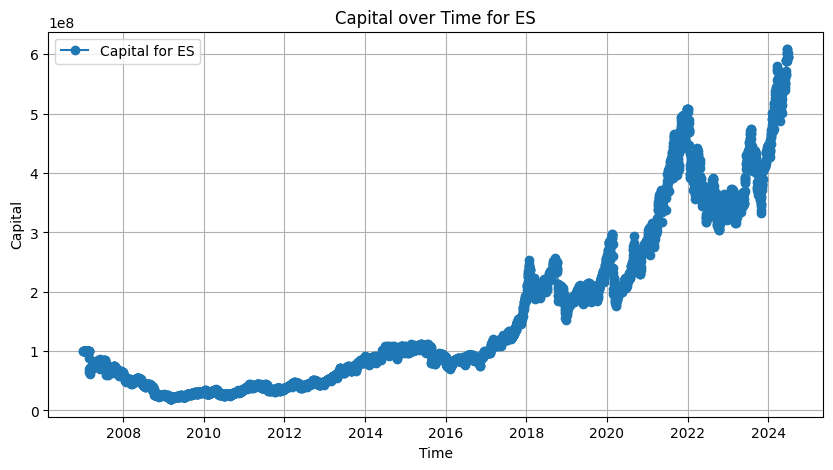

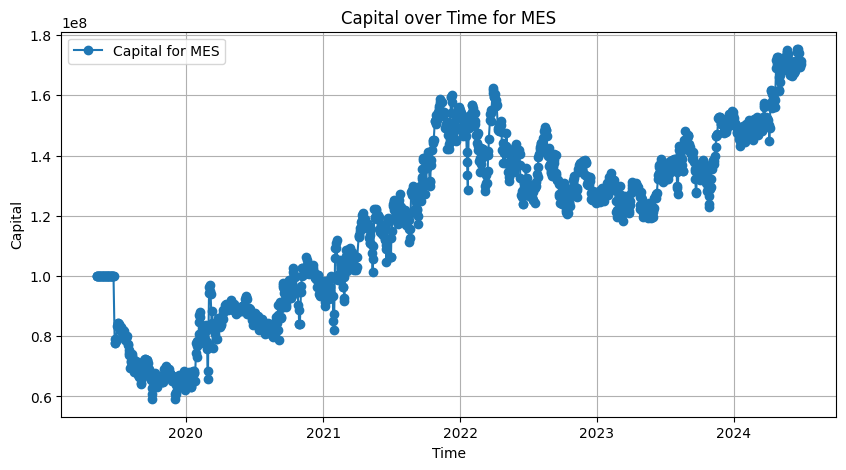

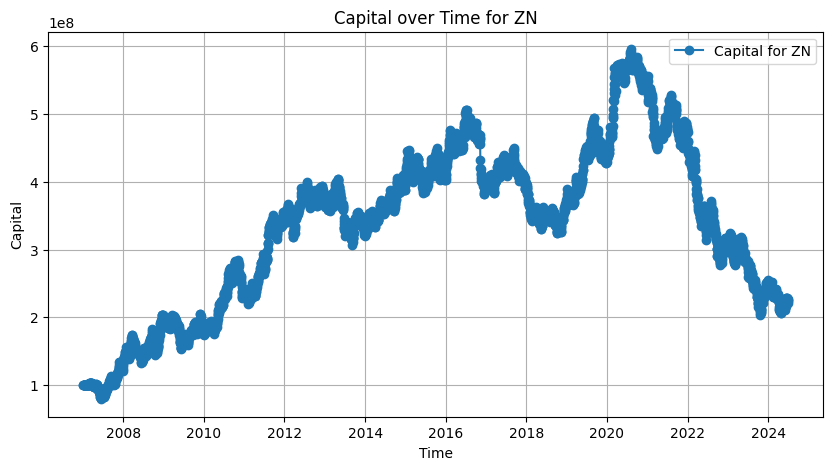

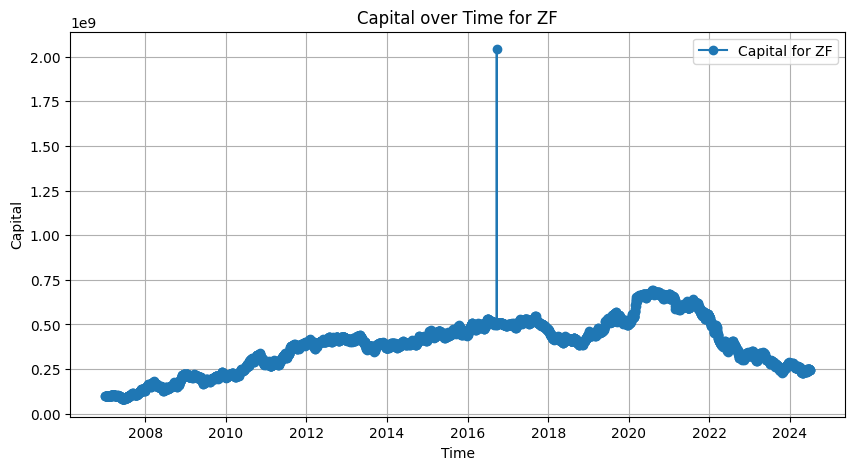

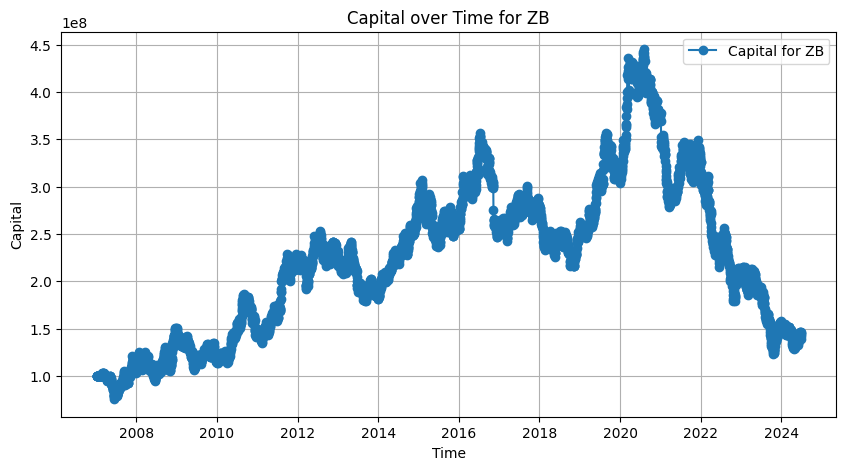

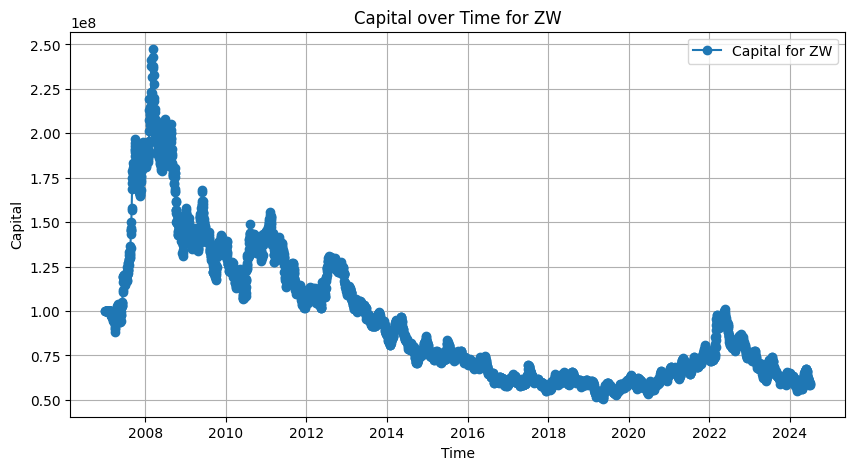

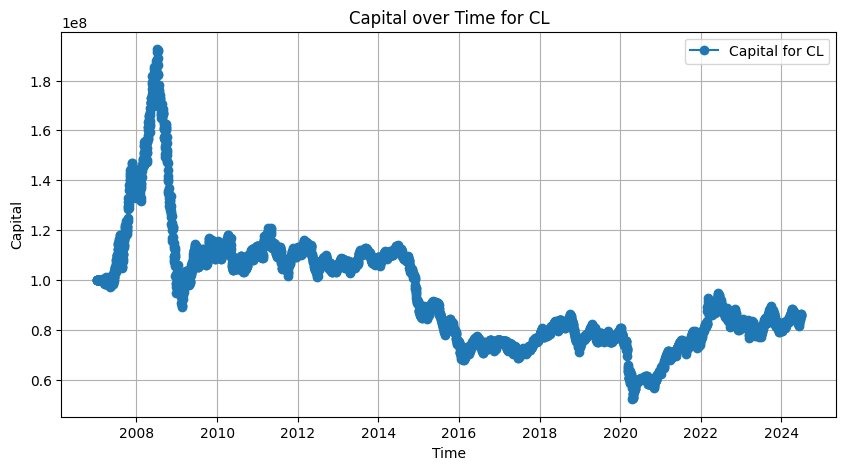

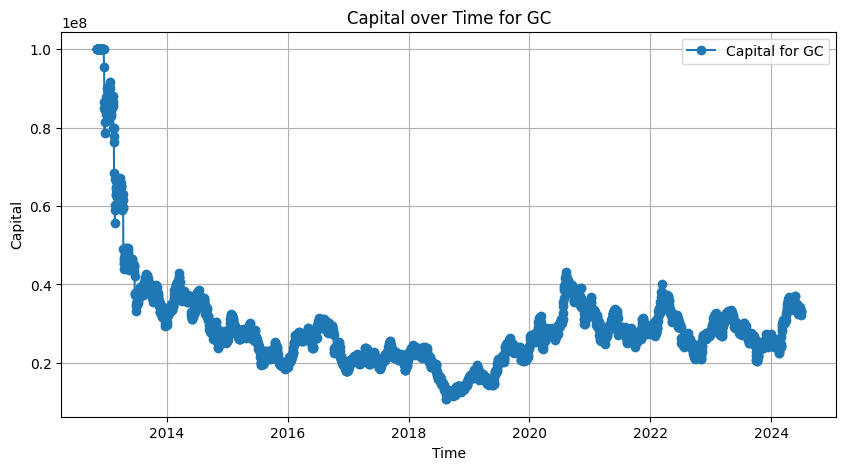

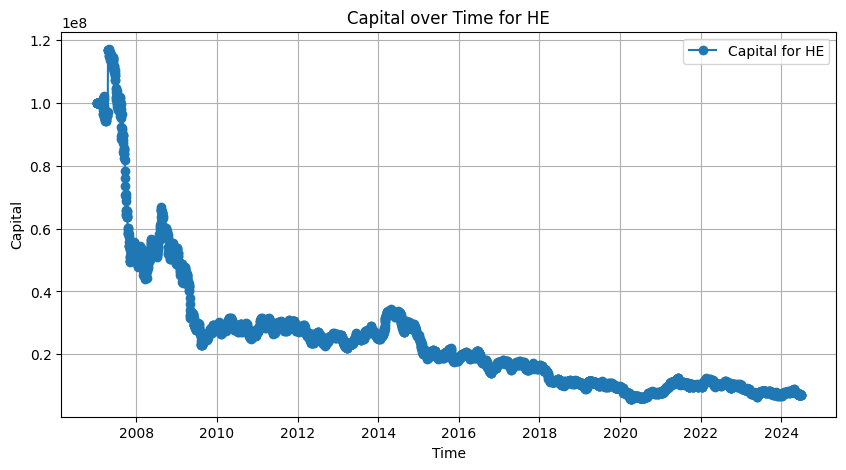

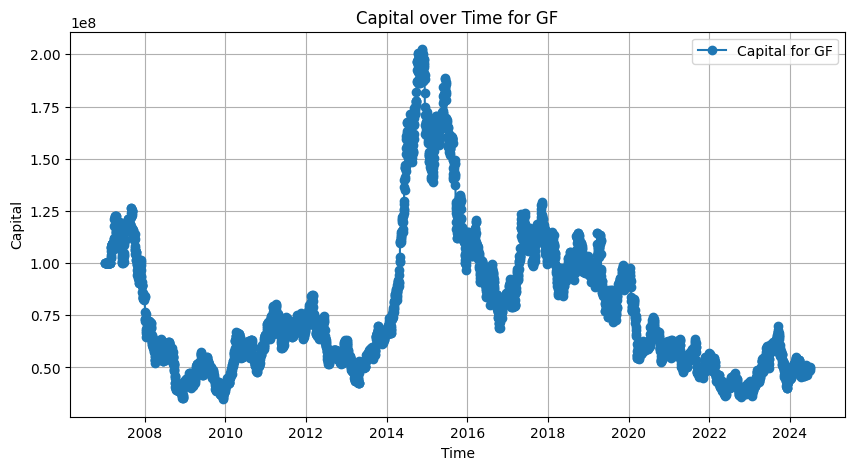

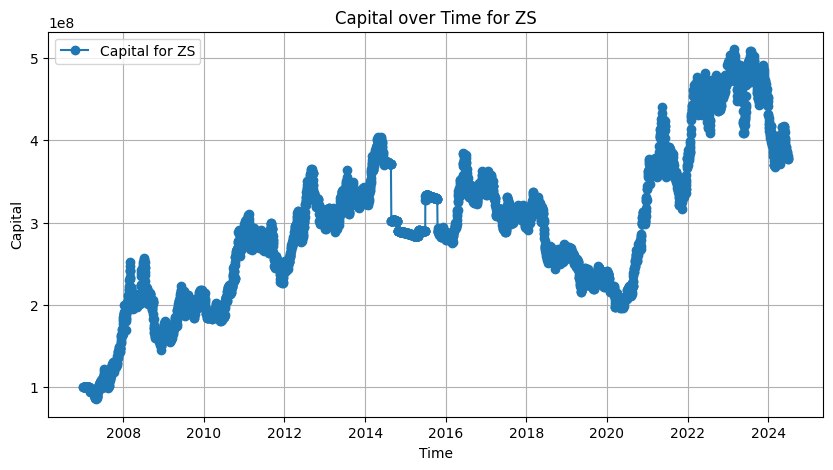

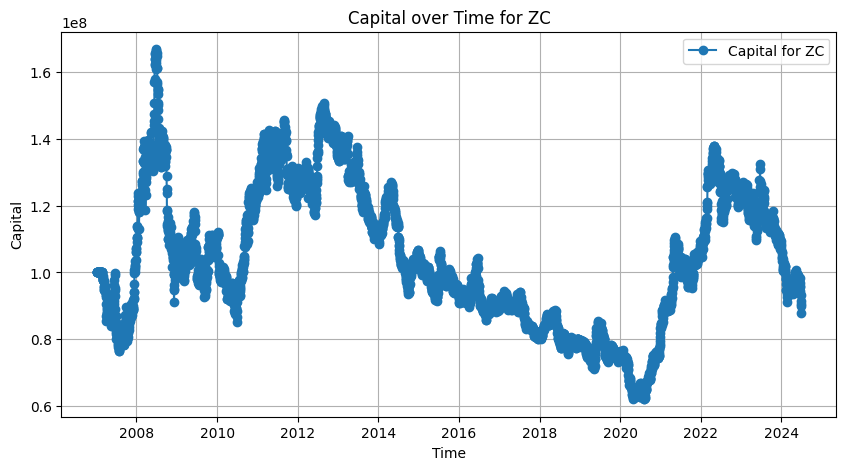

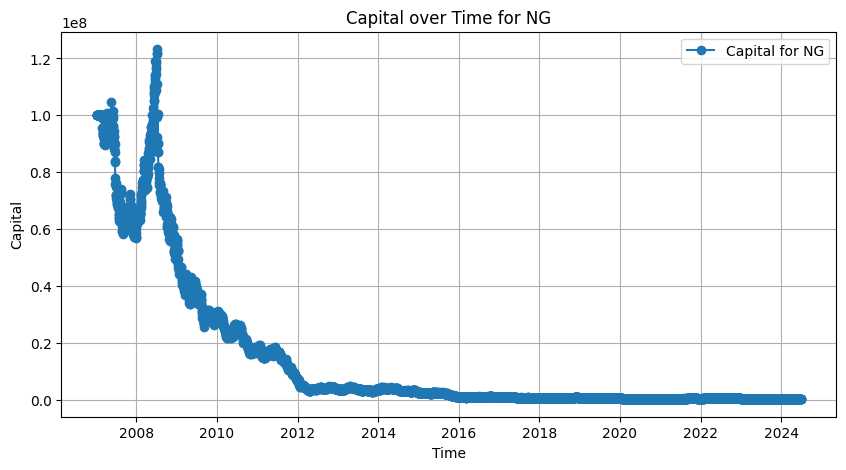

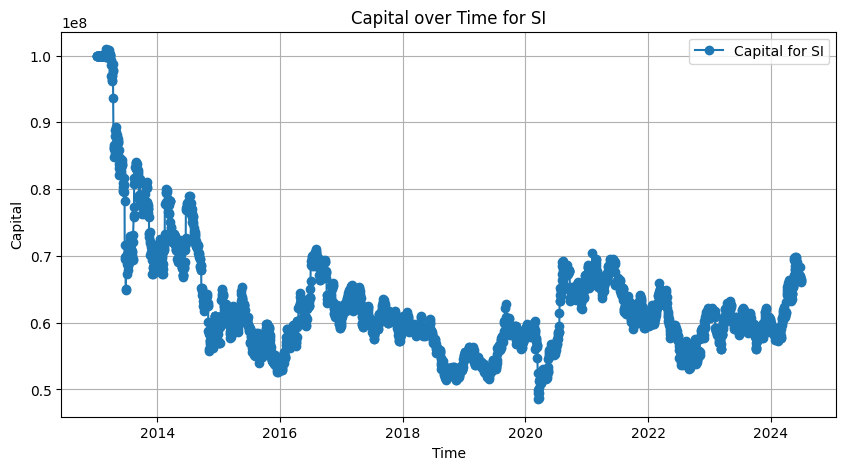

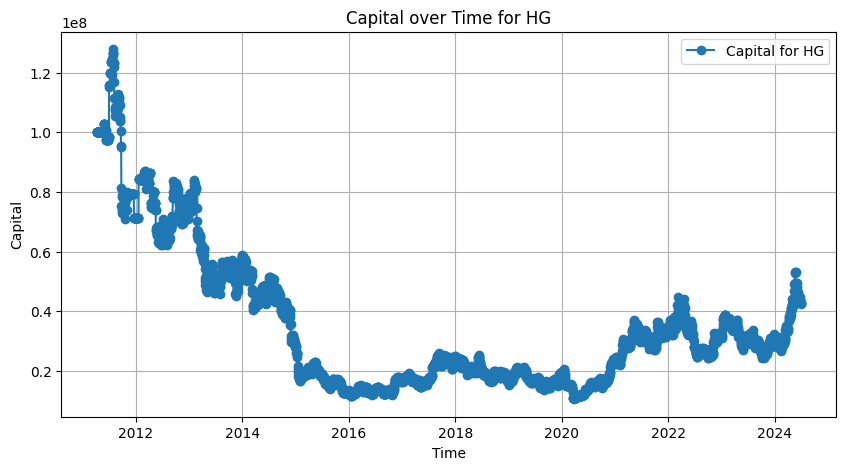

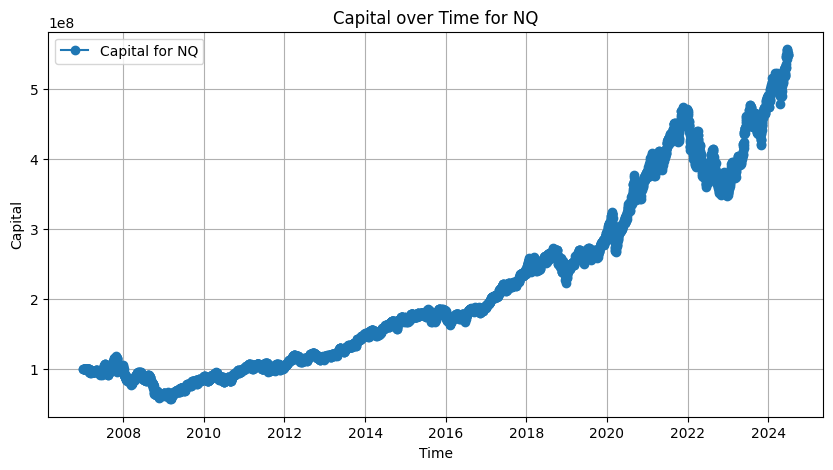

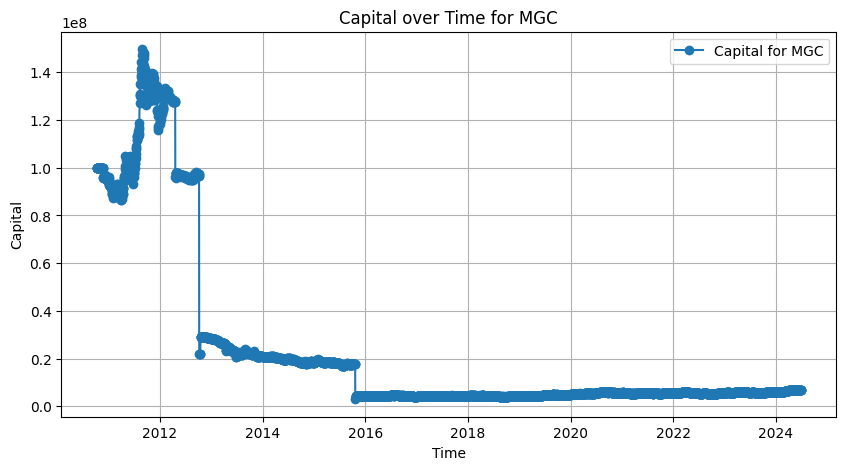

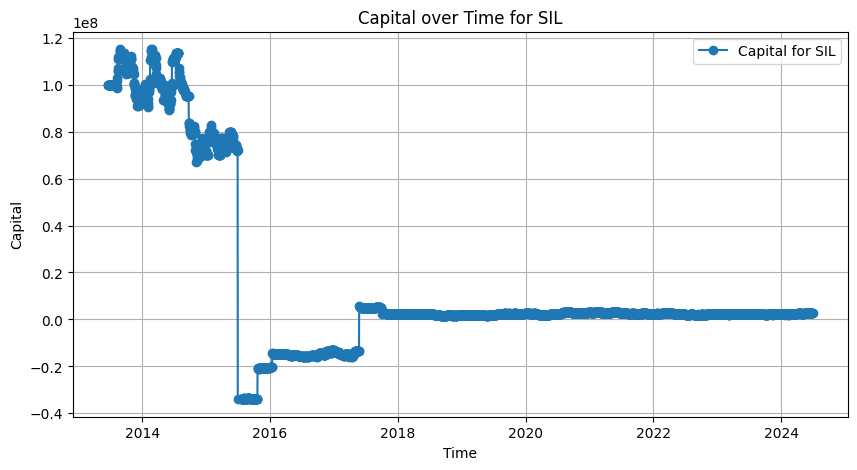

In [60]:
import matplotlib.pyplot as plt

def plot_capital_per_instrument_separately(results):
    symbols = results['symbol'].unique()
    for symbol in symbols:
        data = results[results['symbol'] == symbol]
        plt.figure(figsize=(10, 5))
        plt.plot(data['time'], data['capital'], label=f'Capital for {symbol}', marker='o', linestyle='-')
        plt.title(f'Capital over Time for {symbol}')
        plt.xlabel('Time')
        plt.ylabel('Capital')
        plt.grid(True)
        plt.legend()
        plt.show()

# Ejecutar la función de visualización
plot_capital_per_instrument_separately(results)


In [58]:
# Filtrar el DataFrame para el símbolo 'NG'
ng_results = results[results['symbol'] == 'NG']

# Guardar el DataFrame filtrado a un archivo CSV
ng_results.to_csv('NG_results.csv', index=False)

print("El archivo 'NG_results.csv' ha sido guardado exitosamente.")


El archivo 'NG_results.csv' ha sido guardado exitosamente.
